# Tutorial 4: Adjoints and Sensitivity Kernels with `pygeoinf`

In the previous tutorials, we treated the `pyslfp` library as a tool for performing specific physical calculations. Now, we will explore its deep integration with the `pygeoinf` library, which provides the powerful mathematical abstractions that are useful in posing and solving associated inverse problems. 

We will show how the entire sea-level fingerprint model can be represented as a single **`LinearOperator`** object. This allows us to move beyond simple forward calculations and into the domain of operator algebra, adjoints, and sensitivity analysis.

This tutorial will cover:
1.  **The Model as a `LinearOperator`:** Wrapping the physics of the `FingerPrint` class into a formal `pygeoinf` operator.
2.  **Reciprocity as the Adjoint Identity:** Revisiting the reciprocity principle from Tutorial 3 and demonstrating that it is equivalent to the formal mathematical "dot-product test" for an operator and its adjoint.
3.  **Calculating Sensitivity Kernels:** Using the **adjoint method** to efficiently calculate the sensitivity of a sea-level measurement at a single point (e.g., Boston) to ice melt anywhere on the globe.

## Setup and Initialization

We start with our standard setup, creating a `FingerPrint` instance with a non-dimensionalization scheme and setting its background state.

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pyslfp as sl
import cartopy.crs as ccrs 

# 1. Initialise the fingerprint model with a standard non-dimensionalisation
standard_nondim = sl.EarthModelParameters.from_standard_non_dimensionalisation()
fp = sl.FingerPrint(lmax=256, earth_model_parameters=standard_nondim)

# 2. Set the background state to the present day
fp.set_state_from_ice_ng()

## 1. The Model as a Linear Operator

The `pyslfp` library allows us to represent the entire physical model as a single `pygeoinf.LinearOperator`. The `as_sobolev_linear_operator` method is the primary way to do this.

* **Domain:** The operator's domain (input space) is a **Sobolev space**. This is a function space for the surface mass load, where we enforce a degree of smoothness. This is often a more physical choice than allowing infinitely rough loads. We must specify a smoothness `order` and a characteristic `scale`.
* **Codomain:** The operator's codomain (output space) is a **`HilbertSpaceDirectSum`**. This is a composite space where each component corresponds to one of the physical outputs: [sea-level change, displacement, gravitational potential, angular velocity].

The resulting operator, which we'll call `A`, encapsulates the entire forward problem.

In [19]:
# Define Sobolev space parameters for the input load
order = 2.0
# The scale is a physical length; we'll set it to 10% of the Earth's radius
scale = 0.05 * fp.mean_sea_floor_radius

# Create the linear operator. A(load) -> [slc, disp, gpc, avc]
# Note that the relative tolerance for the solver can be optionally set. 
# For the tests below, a high accuracy is needed. 
A = fp.as_sobolev_linear_operator(order, scale, rtol=1.e-10)


## 2. Reciprocity as the Adjoint Identity

In Tutorial 3, we demonstrated that the sea-level equation obeys a reciprocity principle. This physical symmetry has a deep connection to the mathematical concept of the **adjoint operator**.

For any linear operator $A$ mapping between two Hilbert spaces, its adjoint $A^*$ is uniquely defined by the following identity:
$$
\langle A u, v \rangle = \langle u, A^* v \rangle
$$
This must hold for any vector $u$ in the domain and $v$ in the codomain. It states that the effect of the operator $A$ on $u$, as "measured" by $v$, is the same as the effect of the adjoint operator $A^*$ on $v$, as "measured" by $u$.

The generalized reciprocity theorem is the physical law that tells us precisely what the adjoint operator $A^*$ is. The `pygeoinf` framework uses this physical knowledge to construct the correct adjoint mapping. The dot-product test is a fundamental check to ensure the implementation is correct.

It is important to note that the full operator $A$ is **not** self-adjoint, because its domain (a space of scalar loads) and codomain (a direct sum of different physical fields) are not the same. However, as we will see, specific sub-problems can be self-adjoint. 



In [20]:
# The dot-product test verifies the adjoint implementation.

# 1. Create a random vector `u` in the domain (a random load)
u = fp.northern_hemisphere_load(fraction=0.5)

# 2. Create a vector `v` in the codomain (a random set of response fields)
v = [
    fp.southern_hemisphere_load(fraction=0.2), # "Adjoint" sea level
    fp.southern_hemisphere_load(fraction=0.1), # "Adjoint" displacement
    fp.northern_hemisphere_load(fraction=0.3), # "Adjoint" gravity
    np.random.randn(2)                         # "Adjoint" angular velocity
]

# 3. Calculate the left-hand side: <A(u), v>
lhs = A.codomain.inner_product(A(u), v)

# 4. Calculate the right-hand side: <u, A*(v)>
rhs = A.domain.inner_product(u, A.adjoint(v))


print(f"Adjoint Identity Test Results:")
print(f"  Left-Hand Side  <A(u), v>: {lhs:.6e}")
print(f"  Right-Hand Side <u, A*(v)>: {rhs:.6e}")
print(f"  Are they close? {np.isclose(lhs, rhs, rtol=1e-6)}")

Adjoint Identity Test Results:
  Left-Hand Side  <A(u), v>: 1.907970e-06
  Right-Hand Side <u, A*(v)>: 1.907971e-06
  Are they close? True



## 3. Constructing an Observation Operator

The full operator `A` is useful, but often we are only interested in a single observation. For instance, we might only have data for sea-level change.

Using `pygeoinf`, we can construct a new operator that maps a load directly to this single observation. We do this by composing `A` with a **projection operator**. The codomain of `A` is a direct sum space, and we can get a projection onto its first component (sea-level change) using `A.codomain.subspace_projection(0)`.

Let's create a new operator `B = P @ A`. This operator represents the specific physical process: **load → sea-level change**. Because the domain and codomain of `B` are the same type of function space (a scalar field on the sphere), the simple reciprocity principle from Tutorial 3 means that this specific operator **is** self-adjoint.

In the next cell, we'll create this operator and then immediately use it to re-calculate the fingerprint from Tutorial 1, showing that it works as expected.


--- Reproducing Fingerprint from Tutorial 1 using the Operator ---


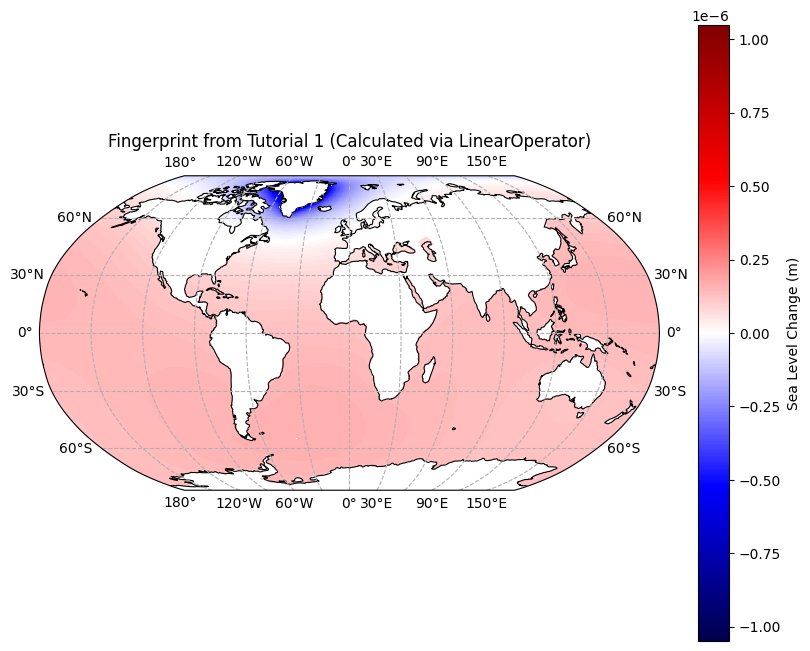

In [21]:
# Get the projection operator onto the first subspace (sea-level change)
P = A.codomain.subspace_projection(0)

# Compose with the full operator to get our specific observation operator
B = P @ A

# --- Use the new operator B to reproduce the result from Tutorial 1 ---

print("\n--- Reproducing Fingerprint from Tutorial 1 using the Operator ---")

# 1. Define the same load as in Tutorial 1
load_tut1 = fp.northern_hemisphere_load(fraction=0.1)

# 2. Apply the operator B to the load
# This is the forward calculation: sea_level_change = B(load)
sea_level_change_op = B(load_tut1)

# 3. Plot the result to confirm it's identical to Tutorial 1
fig, ax, im = sl.plot(
    sea_level_change_op * fp.ocean_projection(),
    coasts=True,
    cmap="seismic",
    symmetric=True
)
ax.set_title("Fingerprint from Tutorial 1 (Calculated via LinearOperator)")
fig.colorbar(im, ax=ax, label="Sea Level Change (m)")
plt.show()

## 4. Calculating a Sensitivity Kernel with the Adjoint Method

Now for the most powerful application. Suppose we want to ask: *"How does a sea-level measurement at a single location (say, Boston) depend on ice melt from every possible location on Earth?"*

The answer to this question is called the **sensitivity kernel**. It's a map that shows how much a small change in the model (ice load) at each point contributes to our specific measurement.

Calculating this kernel directly would require running the forward model thousands of times. The **adjoint method** allows us to compute it with a single operation. The principle is:

> The sensitivity kernel is the result of applying the adjoint of the observation operator ($B^*$) to a representation of the measurement itself.

For a point measurement, this representation is the **Dirac delta functional**. The `pygeoinf` Sobolev space provides the Riesz representation of this functional via the `dirac_representation` method.

In [22]:
# Define the location of our observation (Boston, MA)
lat_boston, lon_boston = 42.36, -71.06

# Get the vector representing a point measurement in the observation space
# Note: The Dirac representation must be in the codomain of B (the sea-level space)
v = B.codomain.dirac_representation((lat_boston, lon_boston))

# Apply the adjoint of our observation operator to this vector
# The result, w, is the sensitivity kernel.
w = B.adjoint(v)

## 5. Visualizing the Sensitivity Kernel

Finally, let's plot the kernel `w`. This map shows the sensitivity of sea level in Boston to a positive mass load (ice gain) anywhere on the globe.

### A Note on Interpretation

It is crucial to understand how to interpret this kernel correctly. Because our operator's domain is a **Sobolev space**, the resulting kernel `w` is also an element of that space. This means it represents the sensitivity functional with respect to the **Sobolev inner product**, not the standard $L^2$ inner product (a simple integral).

The practical implication is that **a simple pointwise interpretation of the kernel's amplitude is not possible.** The influence of a given load pattern, $\zeta$, on the sea level in Boston is given by the Sobolev inner product $\langle w, \zeta \rangle_s$, which involves derivatives and penalizes roughness.

This is a subtle but important technical point that was knowingly simplified in Al-Attar et al. (2023), where the adjoint load was smoothed to allow for a more intuitive visualization and to avoid numerical ringing. The kernel we have computed here is the more mathematically direct representation.

With that caveat in mind, the *pattern* of the kernel is still highly informative. Let's visualize it, and also see its values over the existing ice sheets by multiplying by `fp.ice_projection()`.

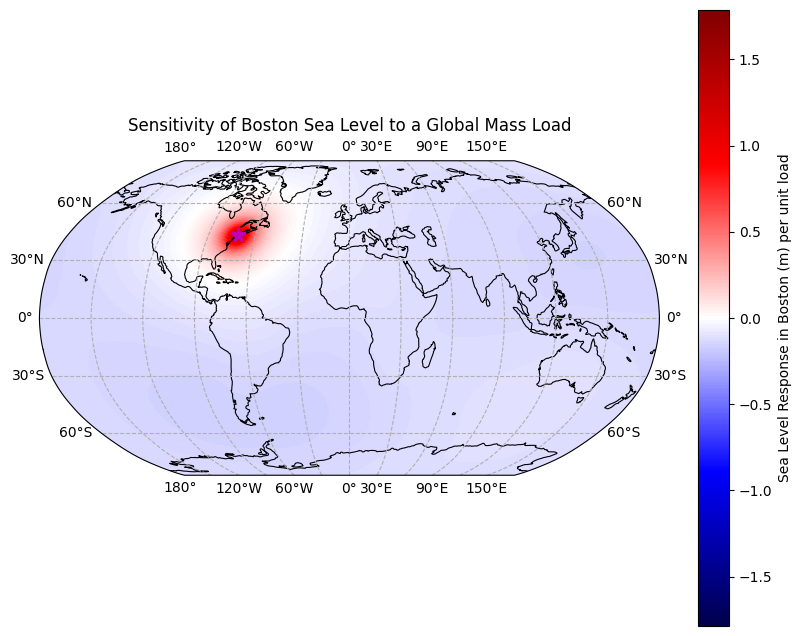

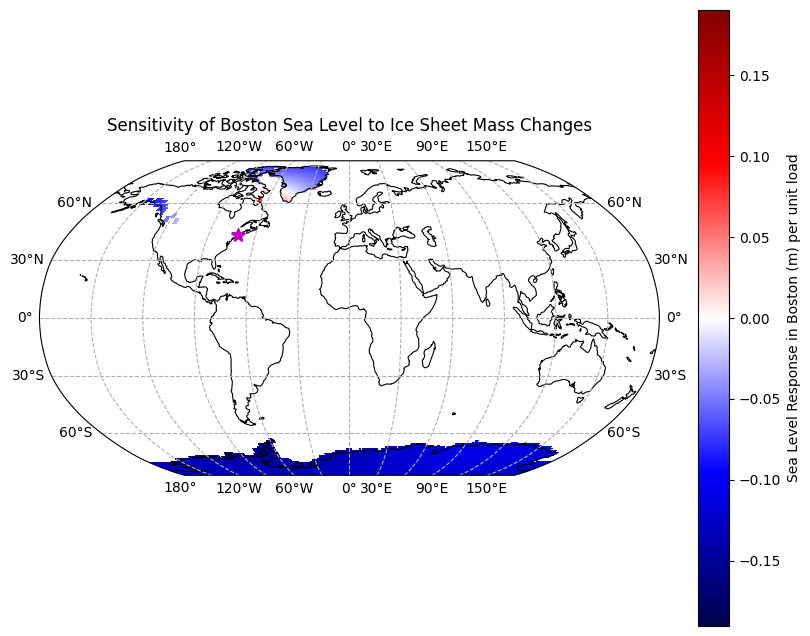

In [23]:
# Plot the full, global sensitivity kernel
fig, ax, im = sl.plot(w, coasts=True, cmap="seismic", symmetric=True)
ax.set_title("Sensitivity of Boston Sea Level to a Global Mass Load")
# Use the imported ccrs module for the transform
ax.plot(lon_boston, lat_boston, 'm*', markersize=10, transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, label="Sea Level Response in Boston (m) per unit load")
plt.show()

# Plot the kernel masked over just the ice sheets
fig, ax, im = sl.plot(w * fp.ice_projection(), coasts=True, cmap="seismic", symmetric=True)
ax.set_title("Sensitivity of Boston Sea Level to Ice Sheet Mass Changes")
# Use the imported ccrs module for the transform
ax.plot(lon_boston, lat_boston, 'm*', markersize=10, transform=ccrs.PlateCarree())
fig.colorbar(im, ax=ax, label="Sea Level Response in Boston (m) per unit load")
plt.show()